In [108]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split , learning_curve
from sklearn.metrics import f1_score , recall_score , confusion_matrix , classification_report , precision_recall_curve
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest , f_classif
from sklearn.preprocessing import PolynomialFeatures , StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV

Starting from the advancement realised by EAD / PreProcessing
This is the optimal shape of our dataset that we could get
Every step of this cell was detailed in the other two scripts

In [109]:
dataset = pd.read_excel("../dataset.xlsx")
feature_presence = dataset.isna().sum() / dataset.shape[0]
feature_continuos_category = list(dataset.columns[(feature_presence < 0.9) & (feature_presence > 0.88)])
feature_categorial_category = list(dataset.columns[(feature_presence < 0.8) & (feature_presence > 0.7)])
dataset = dataset[feature_continuos_category + ['Patient age quantile', "SARS-Cov-2 exam result"] + feature_categorial_category]
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=0)

convert = {
    'negative': 0,
    'not_detected': 0,
    'positive': 1,
    'detected': 1
}
def encodage(dataset):
    for col in dataset.select_dtypes("object"):
        dataset[col]=dataset[col].map(convert)
    return dataset

def feature_engineering(dataset):
    dataset['infected_by_any_type'] = dataset[feature_categorial_category].sum(axis=1) >= 1
    dataset = dataset.drop(feature_categorial_category,axis=1)
    return dataset

def imputation(dataset):
    dataset = dataset.dropna()
    return dataset

def preprocessing(dataset):
    dataset = encodage(dataset)
    dataset = feature_engineering(dataset)
    dataset = imputation(dataset)
    target = dataset["SARS-Cov-2 exam result"]
    dataset=dataset.drop("SARS-Cov-2 exam result",axis=1)
    return dataset , target

x_train , y_train = preprocessing(train_set)
x_test , y_test = preprocessing(test_set)

def evaluation(model):
    model.fit(x_train,y_train)
    y_predicted = model.predict(x_test)
    print(confusion_matrix(y_true=y_test , y_pred= y_predicted),classification_report(y_true=y_test,y_pred=y_predicted))
    N , train_score , val_score = learning_curve(model,x_train,y_train,cv=5,scoring='f1',random_state=0,train_sizes=np.linspace(0.1,1,10))
    plt.figure()
    plt.plot(N,train_score.mean(axis=1),label="Train Score")
    plt.plot(N,val_score.mean(axis=1),label="Validation Score")
    plt.legend()
    plt.show()

Creating a transformer

In [110]:
transformer = make_pipeline(PolynomialFeatures(2,include_bias=False),SelectKBest(f_classif,k=10))

Finding the best model with default hyperparameters

RandomForest
[[91  4]
 [11  5]]               precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111



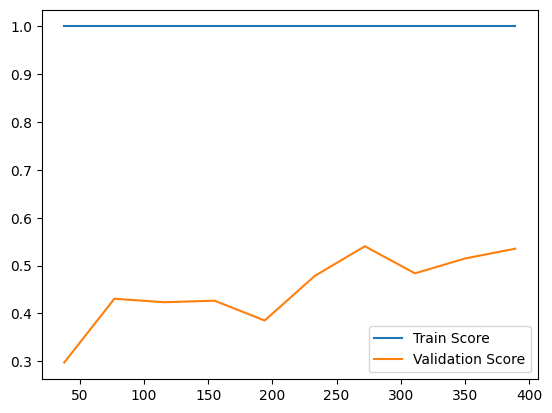

AdaBoost
[[91  4]
 [ 9  7]]               precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



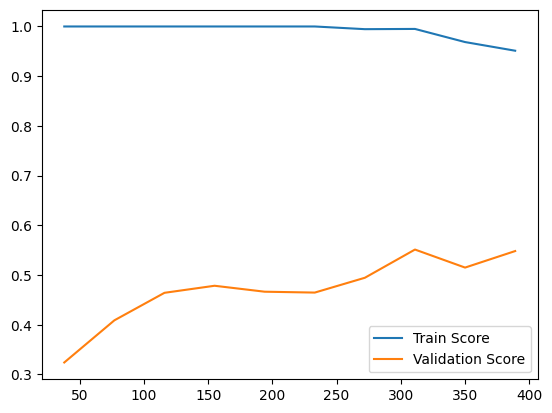

SVC
[[92  3]
 [10  6]]               precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71       111
weighted avg       0.87      0.88      0.87       111



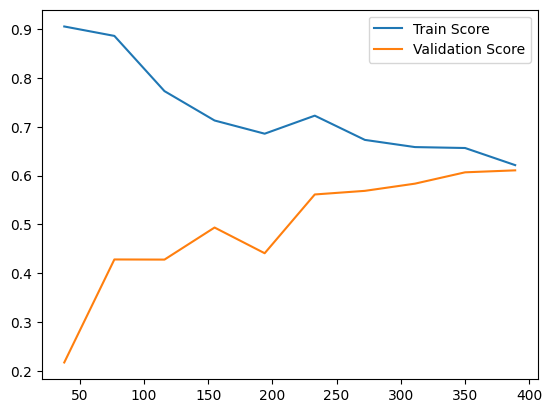

Kneighbors
[[88  7]
 [ 8  8]]               precision    recall  f1-score   support

           0       0.92      0.93      0.92        95
           1       0.53      0.50      0.52        16

    accuracy                           0.86       111
   macro avg       0.72      0.71      0.72       111
weighted avg       0.86      0.86      0.86       111



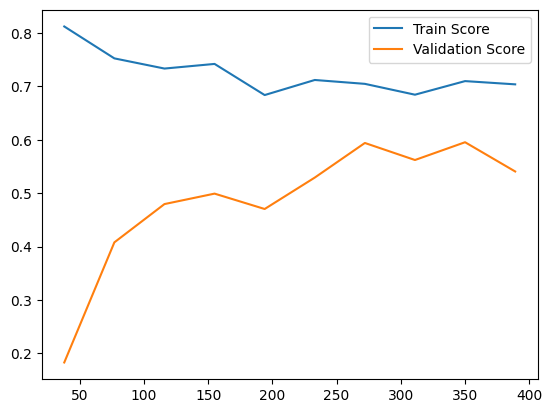

In [111]:
RandomForest = make_pipeline(transformer,RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(transformer,AdaBoostClassifier(random_state=0))
SVC = make_pipeline(transformer,StandardScaler(),SVC(random_state=0))
Kneighbors = make_pipeline(transformer,StandardScaler(),KNeighborsClassifier())

models = {
    'RandomForest' : RandomForest,
    'AdaBoost' : AdaBoost,
    'SVC' : SVC,
    'Kneighbors' : Kneighbors
}

for key,value in models.items():
    print(key)
    evaluation(value)

SVC - Optimization

Using GridSearchCV

[[91  4]
 [ 9  7]]               precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



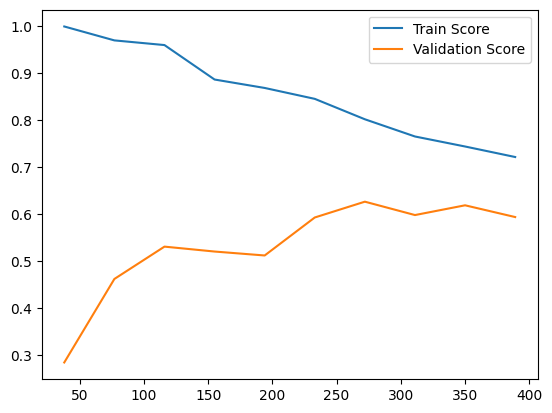

In [112]:
svc_gridsearch_params = {
    'svc__gamma' : [1e-4,1e-2,0.1,0,8,1e-3],
    'svc__C' : [1e-2,0.1,1,100,1000]
}

grid = GridSearchCV(SVC,param_grid=svc_gridsearch_params,scoring='recall',cv=4)
grid.fit(x_train,y_train)
best_gridsearch_SVC_model = grid.best_estimator_
evaluation(best_gridsearch_SVC_model)

Using RandomizedSearchCV

{'svc__gamma': 0.0005, 'svc__C': 1000, 'pipeline__selectkbest__k': 53, 'pipeline__polynomialfeatures__degree': 3}
[[90  5]
 [ 8  8]]               precision    recall  f1-score   support

           0       0.92      0.95      0.93        95
           1       0.62      0.50      0.55        16

    accuracy                           0.88       111
   macro avg       0.77      0.72      0.74       111
weighted avg       0.87      0.88      0.88       111



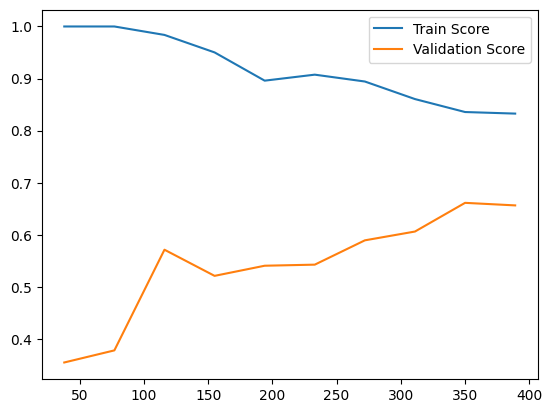

In [113]:
svc_randomizedsearch_params = {
    'svc__gamma' : [1e-4, 0.0005],
    'svc__C' : [100, 1000, 3000],
    'pipeline__polynomialfeatures__degree' : [2,3],
    'pipeline__selectkbest__k' : range(40,60)
}

randomized_search = RandomizedSearchCV(SVC,param_distributions=svc_randomizedsearch_params,cv=4,scoring='recall',n_iter=40)
randomized_search.fit(x_train,y_train)
best_randomizedsearch_SVC_model=randomized_search.best_estimator_
print(randomized_search.best_params_)
evaluation(best_randomizedsearch_SVC_model)

Finding the best Threshold value

In [114]:
def threshold_visualisation(model):
    precision , recall , threshold = precision_recall_curve(y_test,model.decision_function(x_test))
    plt.figure()
    plt.plot(threshold,precision[:-1],label='precision score')
    plt.plot(threshold,recall[:-1],label='recall score')
    plt.legend()
    plt.show()

def fixed_threshold(model,threshold):
    generated_prediction = model.decision_function(x_test) > threshold
    return generated_prediction

def best_threshold(model,values):
    result = []
    for elt in values :
        elt_pred = fixed_threshold(model , threshold=elt)
        elt_recall = recall_score(y_test,elt_pred)
        elt_f1 = f1_score(y_test,elt_pred)
        if (elt_f1>=0.5) & (elt_recall>=0.7):
            result.append((elt_recall,elt))
    return max(result)[1]

SVC - Final model

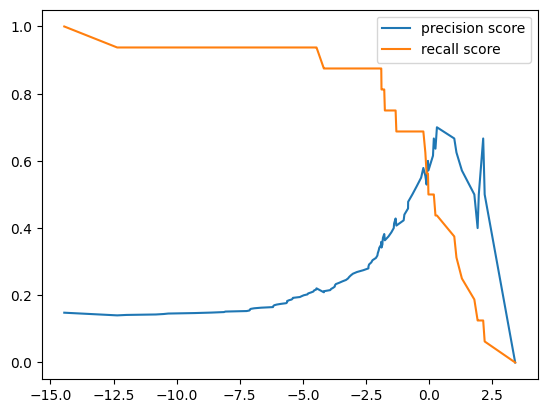

The best threshold value to meet our objectives is :  -1.8947368421052633
SVC final recall score :  0.875
SVC final f1 score :  0.509090909090909
[[70 25]
 [ 2 14]]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84        95
           1       0.36      0.88      0.51        16

    accuracy                           0.76       111
   macro avg       0.67      0.81      0.67       111
weighted avg       0.88      0.76      0.79       111



In [115]:
threshold_visualisation(best_randomizedsearch_SVC_model)
SVC_best_threshold = best_threshold(best_randomizedsearch_SVC_model,np.linspace(-2,0,20))
print("The best threshold value to meet our objectives is : ",SVC_best_threshold)
y_pred = fixed_threshold(best_randomizedsearch_SVC_model , threshold=SVC_best_threshold)
print("SVC final recall score : ",recall_score(y_test,y_pred))
print("SVC final f1 score : ",f1_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))